# GlazeAlarm 2023
## Sensor 1: Front Door Data

In [1]:
# Thai - Install Libraries
!pip install kaggle

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub
from datetime import datetime
import seaborn as sns
from scipy.stats import zscore
import chardet

In [3]:
# Thai's File Path for Sensor Data [Front Door, EcoLab Ground, and Weather Link Indoor]

# Set up Kaggle credentials
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write('{"username":"outhaixayavongsa","key":"5685fcfdd6dbfd572a5f2cb9fc786009"}')

# Set permissions for the Kaggle API key file
!chmod 600 /root/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d ssiatuos/smart-house-data-pack --quiet

# Unzip the downloaded file
!unzip -o smart-house-data-pack.zip -d ./smart-house-data-pack/ > /dev/null

# Path to the Front Door CSV file
data = "./smart-house-data-pack/Smart House 2023 datapack CC BY-NC/GlazeAlarm 2023/Front Door.csv"  # Sensor 1 - Front Door

# Check if the file exists
if os.path.exists(data):
    try:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(data, header=0, index_col=False)
        print("Front Door Dataset loaded successfully!")
    except Exception as e:
        print(f"Error loading Front Door dataset: {e}")

# Path to the EcoLab Ground CSV file
EcoLab_data = "./smart-house-data-pack/Smart House 2023 datapack CC BY-NC/Invisible Systems 2023/EcoLab Ground.csv"  # Sensor 2 - EcoLab Ground

# Check if the file exists
if os.path.exists(EcoLab_data):
    try:
        # Load the CSV file into a DataFrame
        df_inv = pd.read_csv(EcoLab_data, header=0, index_col=False, engine="python")
        print("EcoLab Ground Dataset loaded successfully!")
    except Exception as e:
        print(f"Error loading EcoLab Ground dataset: {e}")

# Path to the Weather Link Indoor CSV file
weather_data = "./smart-house-data-pack/Smart House 2023 datapack CC BY-NC/WeatherLink Indoor and Outdoor 2023/Weather Link Indoor.csv"  # Sensor 3 - Weather Link Indoor

# Detect encoding to handle special characters in the dataset
with open(weather_data, "rb") as f:
    encoding_result = chardet.detect(f.read())
detected_encoding = encoding_result.get("encoding", "ISO-8859-1")

# Load the Weather Link Indoor dataset
try:
    df_wLink = pd.read_csv(
        weather_data,
        engine="python",
        encoding=detected_encoding,
        skiprows=5
    )
    print("Weather Link Indoor Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading Weather Link Indoor dataset: {e}")

Dataset URL: https://www.kaggle.com/datasets/ssiatuos/smart-house-data-pack
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
Front Door Dataset loaded successfully!
EcoLab Ground Dataset loaded successfully!
Weather Link Indoor Dataset loaded successfully!


### Data Understanding and EDA

In [4]:
# Shape of DataFrame
df.shape

(1185, 7)

In [5]:
# Dataframe Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Timestamp      1185 non-null   object
 1   Serial Number  1185 non-null   int64 
 2   Name           1185 non-null   object
 3   Mode           1185 non-null   object
 4   Alarm          1185 non-null   object
 5   rH             1185 non-null   object
 6   Temp           1185 non-null   object
dtypes: int64(1), object(6)
memory usage: 64.9+ KB


In [6]:
# Display the first 5 rows of the dataset
df_head = df.head(5)

# Display the last 5 rows of the dataset
df_tail = df.tail(5)

df_head
df_tail

,Timestamp,Serial Number,Name,Mode,Alarm,rH,Temp
1180,2022-03-28 15:41:09,1095,Front Door,LEARNING,RESET,-,-
1181,2022-03-23 19:30:38,1095,Front Door,STATE,PRE-WARN,36.5,25
1182,2022-03-23 19:30:32,1095,Front Door,STATE,RESET,36.5,25
1183,2022-03-23 19:29:50,1095,Front Door,STATE,PRE-WARN,38.1,21.1
1184,2022-03-23 19:29:43,1095,Front Door,LEARNING,RESET,-,-


In [7]:
# Missing Data
df.isnull().sum()

,0
Timestamp,0
Serial Number,0
Name,0
Mode,0
Alarm,0
rH,0
Temp,0


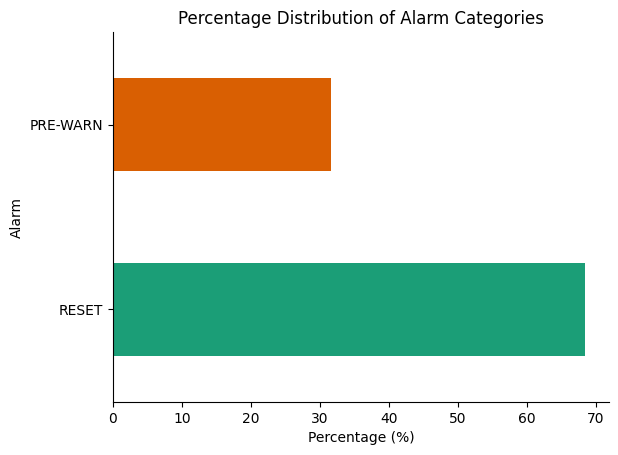

In [8]:
# Calculate the percentage of each 'Alarm' category
alarm_counts = df['Alarm'].value_counts(normalize=True) * 100

# Plot the horizontal bar chart with percentages
alarm_counts.plot(kind='barh', color=sns.color_palette('Dark2', len(alarm_counts)))

# Display chart
plt.xlabel('Percentage (%)')
plt.ylabel('Alarm')
plt.title('Percentage Distribution of Alarm Categories')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

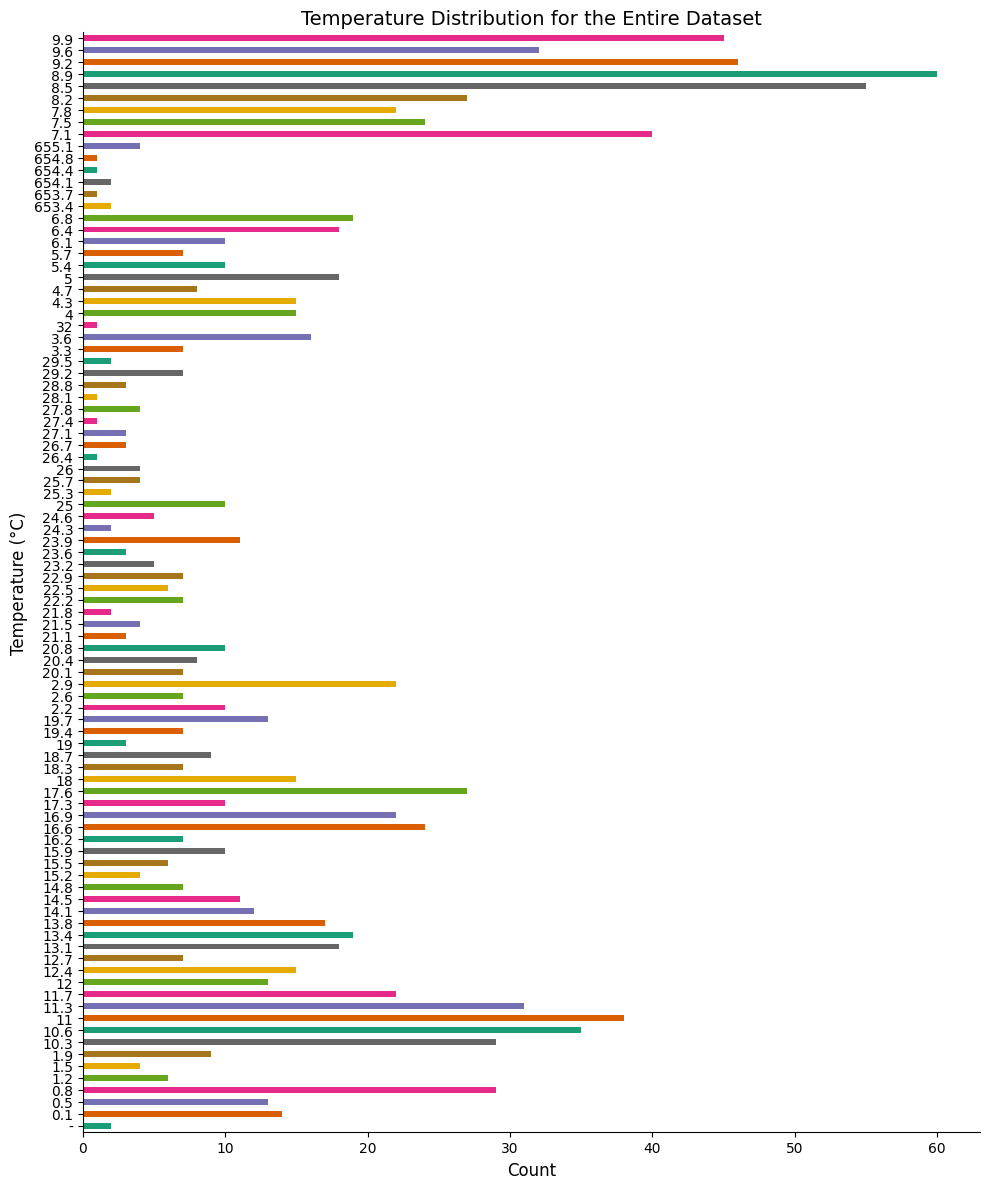

In [9]:
# Check if the original dataset is not empty
if not df.empty:
    # Group by 'Temp' column and plot the distribution for the entire dataset with a larger figure size
    plt.figure(figsize=(10, 12))
    df.groupby('Temp').size().plot(kind='barh', color=sns.color_palette('Dark2'))

    # Add labels and title
    plt.title('Temperature Distribution for the Entire Dataset', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()
else:
    print("The dataset is empty. Cannot plot temperature distribution.")

*Values like 653.7°C are unrealistic so I will need to correct temperatures above 50°C*

### Data Clean and Preprocessing

In [10]:
# Convert the 'Temp' column to numeric, replacing non-numeric values with NaN
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')

# Replace anomalous high temperature values (above a reasonable threshold) with NaN
reasonable_temp_threshold = 50  # Assuming temperatures above 50°C are unrealistic
df['Temp'] = df['Temp'].where(df['Temp'] <= reasonable_temp_threshold, np.nan)

# Fill NaN values with the mean temperature of the dataset (after removing anomalies)
mean_temp = df['Temp'].mean(skipna=True)
df['Temp'] = df['Temp'].fillna(mean_temp)

# Verify the changes
print(df['Temp'].describe())

count    1185.000000
mean       11.173976
std         6.354127
min         0.100000
25%         7.100000
50%         9.900000
75%        14.800000
max        32.000000
Name: Temp, dtype: float64


*The 25th percentile is 7.1°C, the median is 9.9°C, and the 75th percentile is 14.8°C, showing a well-spread distribution.*

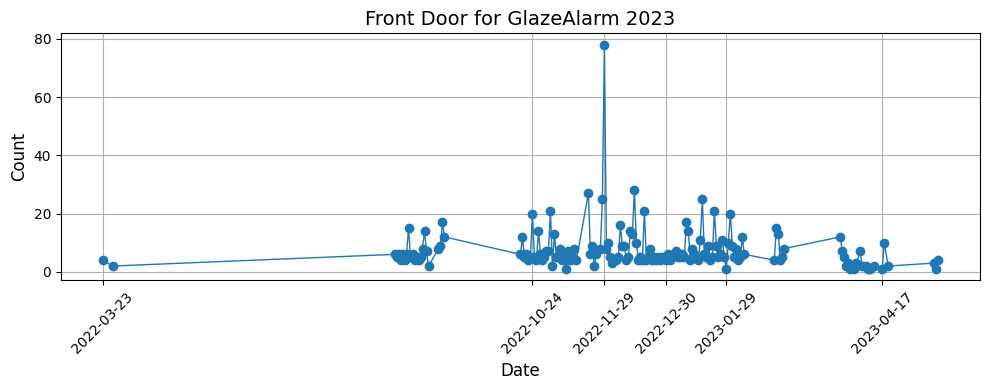

In [11]:
# Convert the 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Sort the DataFrame by 'Timestamp'
df = df.sort_values(by='Timestamp')

# Group data by date for the line chart
df['Date'] = df['Timestamp'].dt.date
daily_data = df.groupby('Date').size()

# Plot the line chart including the full timestamp
plt.figure(figsize=(10, 4))
plt.plot(daily_data.index, daily_data.values, marker='o', linestyle='-', linewidth=1)
plt.title('Front Door for GlazeAlarm 2023', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)
plt.xticks(daily_data.index[::30], rotation=45)
plt.tight_layout()
plt.show()

*Further Analysis is needed for the Outlier shown in the chart*

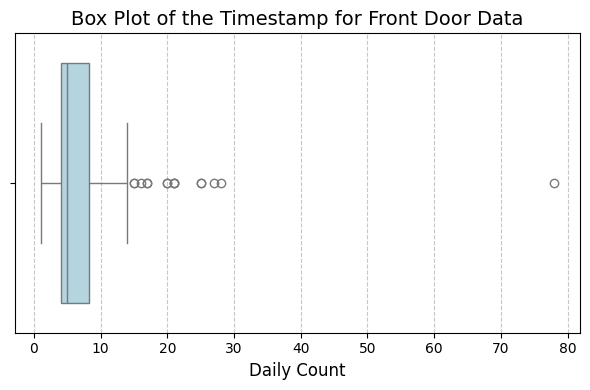

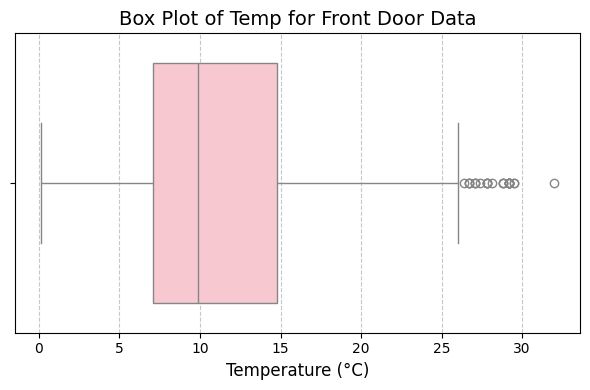

In [12]:
# Boxplot display
daily_counts = df.groupby('Date').size().reset_index(name='Count')

# Create a box plot for the daily counts to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=daily_counts['Count'], color='lightblue')
plt.title('Box Plot of the Timestamp for Front Door Data', fontsize=14)
plt.xlabel('Daily Count', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a box plot for the 'Temp' column to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['Temp'], color='pink')
plt.title('Box Plot of Temp for Front Door Data', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
# Identify the date corresponding to the outlier in daily counts
outlier_threshold = daily_counts['Count'].quantile(0.75) + 1.5 * (daily_counts['Count'].quantile(0.75) - daily_counts['Count'].quantile(0.25))

# Filter for outlier days
outlier_days = daily_counts[daily_counts['Count'] > outlier_threshold]

# Display the outlier days and their counts
outlier_days

,Date,Count
9,2022-08-23,15
22,2022-09-09,17
30,2022-10-24,20
39,2022-11-02,21
53,2022-11-21,27
59,2022-11-28,25
60,2022-11-29,78
67,2022-12-07,16
74,2022-12-14,28
79,2022-12-19,21


*The outlier on 2022-11-29 is valid and reflects real activity logged by the system so a correction isn't needed*

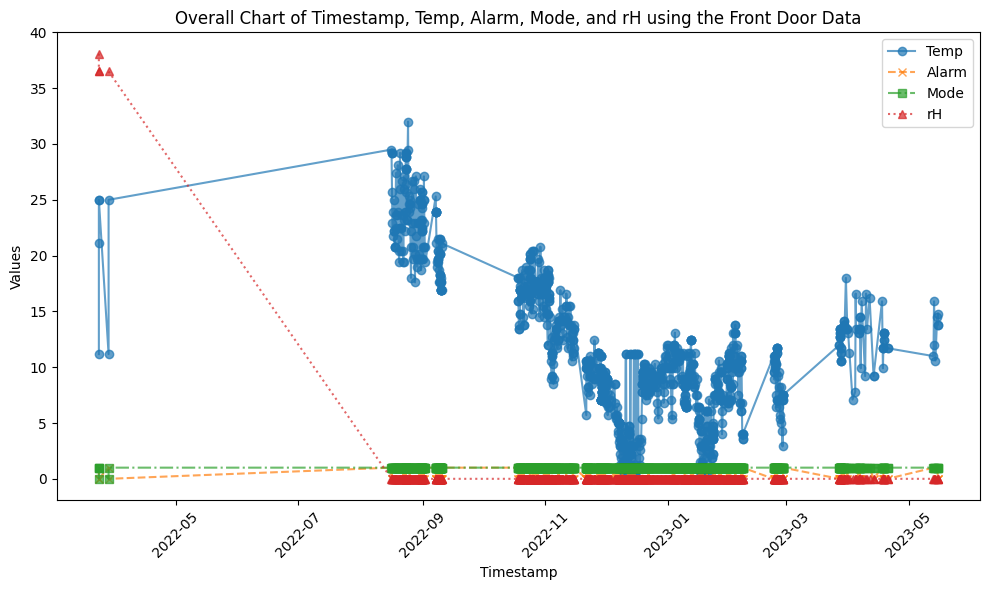

In [14]:
# Convert non-numerical values in 'Mode' and 'Alarm' columns to numerical
df['Mode'] = df['Mode'].astype('category').cat.codes
df['Alarm'] = df['Alarm'].astype('category').cat.codes

# Step 3: Plot a combined graph for Timestamp, Alarm, Mode, rH, and Temp
plt.figure(figsize=(10, 6))

# Timestamp vs Temp
plt.plot(df['Timestamp'], df['Temp'], label='Temp', marker='o', linestyle='-', alpha=0.7)

# Timestamp vs Alarm
plt.plot(df['Timestamp'], df['Alarm'], label='Alarm', marker='x', linestyle='--', alpha=0.7)

# Timestamp vs Mode
plt.plot(df['Timestamp'], df['Mode'], label='Mode', marker='s', linestyle='-.', alpha=0.7)

# Timestamp vs rH
df['rH'] = pd.to_numeric(df['rH'], errors='coerce')
plt.plot(df['Timestamp'], df['rH'], label='rH', marker='^', linestyle=':', alpha=0.7)

# Adding labels, legend, and layout adjustments
plt.title('Overall Chart of Timestamp, Temp, Alarm, Mode, and rH using the Front Door Data')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Confirm the correction
print(df['rH'].describe())

count    1183.000000
mean        0.124768
std         2.143330
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        38.100000
Name: rH, dtype: float64


*The statistics confirm that the rH data is highly skewed and dominated by zeros, making it less meaningful for modeling purposes. It is reasonable to drop the rH column as it doesn't add significant value to the objective or target variable prediction.*

In [16]:
# Drop the 'rH', 'Serial Number', and 'Name' columns from the dataset
df_cleaned = df.drop(columns=['rH', 'Serial Number', 'Name'])

In [17]:
# Define the cutoff date
cutoff_date = '2022-08-15'

# Convert the cutoff date to a datetime object
cutoff_date = pd.to_datetime(cutoff_date)

# Filter the dataset and create a new copy to avoid SettingWithCopyWarning
df_cleaned1 = df_cleaned[df_cleaned['Timestamp'] >= cutoff_date].copy()

# Handle Missing or Erroneous Temperature Values
df_cleaned1['Temp'] = pd.to_numeric(df_cleaned1['Temp'], errors='coerce')  # Convert Temp to numeric
reasonable_temp_threshold = 50  # Define a reasonable max Temp
df_cleaned1['Temp'] = df_cleaned1['Temp'].where(df_cleaned1['Temp'] <= reasonable_temp_threshold, np.nan)  # Replace outliers
df_cleaned1['Temp'] = df_cleaned1['Temp'].interpolate(method='linear', limit_direction='both')  # Interpolate missing values

# Convert and Validate Timestamp
df_cleaned1['Timestamp'] = pd.to_datetime(df_cleaned1['Timestamp'], errors='coerce')  # Convert to datetime
df_cleaned1 = df_cleaned1.dropna(subset=['Timestamp'])  # Drop rows with invalid timestamps

# Validate `Mode` and `Alarm` Columns
# Ensure all values in Mode and Alarm are within a valid range
if df_cleaned1['Mode'].isnull().any() or df_cleaned1['Alarm'].isnull().any():
    print("Warning: Null values found in Mode or Alarm columns. Consider imputing them.")

# Validate and Display Final Cleaned Data
print("Cleaned Data After 8/15/2022:")
print(df_cleaned1.info())
print(df_cleaned1.head())

Cleaned Data After 8/15/2022:
<class 'pandas.core.frame.DataFrame'>
Index: 1179 entries, 1178 to 0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  1179 non-null   datetime64[ns]
 1   Mode       1179 non-null   int8          
 2   Alarm      1179 non-null   int8          
 3   Temp       1179 non-null   float64       
 4   Date       1179 non-null   object        
dtypes: datetime64[ns](1), float64(1), int8(2), object(1)
memory usage: 39.1+ KB
None
               Timestamp  Mode  Alarm  Temp        Date
1178 2022-08-16 11:24:21     1      1  29.5  2022-08-16
1177 2022-08-16 12:16:09     1      0  29.2  2022-08-16
1176 2022-08-16 12:16:53     1      1  29.2  2022-08-16
1175 2022-08-16 12:17:12     1      0  29.2  2022-08-16
1174 2022-08-16 17:37:52     1      1  25.7  2022-08-16


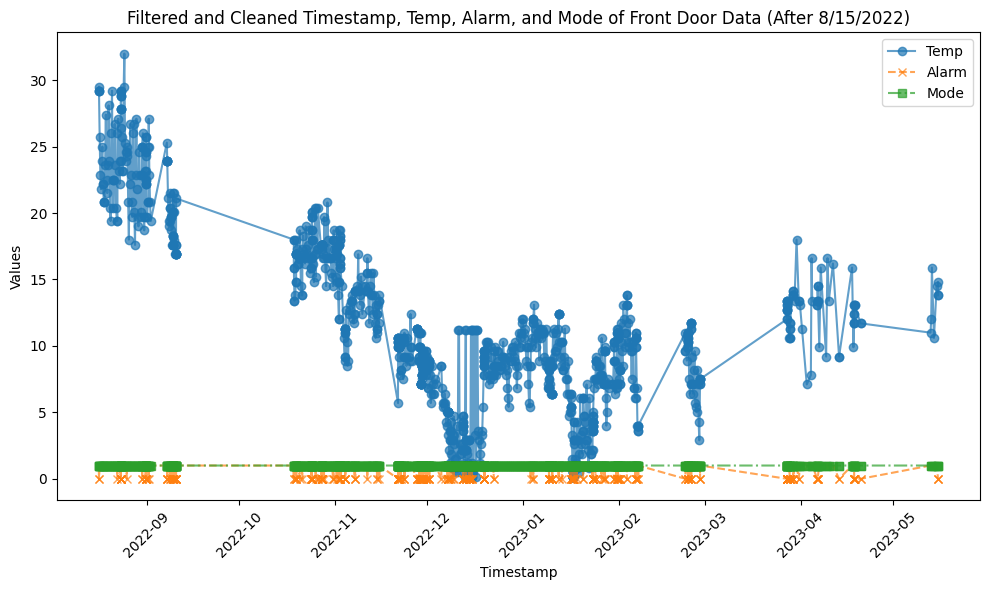

In [18]:
# Visualize the updated data to confirm
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned1['Timestamp'], df_cleaned1['Temp'], label='Temp', marker='o', linestyle='-', alpha=0.7)
plt.plot(df_cleaned1['Timestamp'], df_cleaned1['Alarm'], label='Alarm', marker='x', linestyle='--', alpha=0.7)
plt.plot(df_cleaned1['Timestamp'], df_cleaned1['Mode'], label='Mode', marker='s', linestyle='-.', alpha=0.7)
plt.title('Filtered and Cleaned Timestamp, Temp, Alarm, and Mode of Front Door Data (After 8/15/2022)')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

*Display Data for Front Door Data in 3 Month Range*

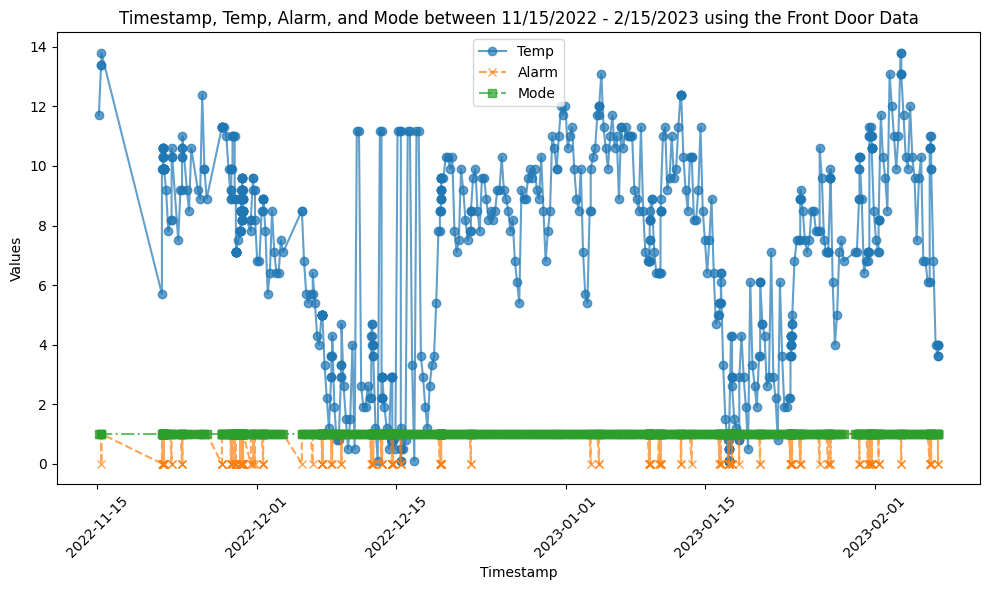

In [49]:
# Filter the DataFrame to include only data between 11/2022 and 2/2023
df_filtered = df_cleaned1[(df_cleaned1['Timestamp'] >= '2022-11-15') & (df_cleaned1['Timestamp'] <= '2023-02-15')]

# Plot the combined graph for the filtered data
plt.figure(figsize=(10, 6))

# Timestamp vs Temp
plt.plot(df_filtered['Timestamp'], df_filtered['Temp'], label='Temp', marker='o', linestyle='-', alpha=0.7)

# Timestamp vs Alarm
plt.plot(df_filtered['Timestamp'], df_filtered['Alarm'], label='Alarm', marker='x', linestyle='--', alpha=0.7)

# Timestamp vs Mode
plt.plot(df_filtered['Timestamp'], df_filtered['Mode'], label='Mode', marker='s', linestyle='-.', alpha=0.7)

# Adding labels, legend, and layout adjustments
plt.title('Timestamp, Temp, Alarm, and Mode between 11/15/2022 - 2/15/2023 using the Front Door Data')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

*Saved Clean Version of Front Door Data to Use for Model Predictions*

In [50]:
# Ensure the directory exists
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)

# Define the output file path
cleaned_df1 = os.path.join(output_dir, "Front Door Cleaned.csv")

# Save the filtered and cleaned dataset
df_cleaned1.to_csv(cleaned_df1, index=False)

# Confirm the save operation
cleaned_df1

'./data/Front Door Cleaned.csv'

# Invisible Systems 2023
## Sensor 2: EcoLab Ground Data

*We are using EcoLab Ground as that has ppm, rH and Temperature. Smarthouse Ground floor has alot more but more sensors that don't have full meaning to this project like IAQ, VOC, Light, Floor pressure and Floor temperature*

In [21]:
# Aaron's File Path
# data = "./Smart House 2023 datapack CC BY-NC/Invisible Systems 2023/EcoLab Ground.csv"

### Data Understanding and EDA



In [22]:
# Check Dataframe
df_inv.head()

,Sensor,DateTime,Value,Max,Min,Unit
0,EcoLab Ground (CO107),2022-12-31 23:53:24,518.0,NaN,NaN,ppm
1,EcoLab Ground (CO107),2023-01-01 00:00:55,520.0,NaN,NaN,ppm
2,EcoLab Ground (CO107),2023-01-01 00:08:23,505.0,NaN,NaN,ppm
3,EcoLab Ground (CO107),2023-01-01 00:15:52,491.0,NaN,NaN,ppm
4,EcoLab Ground (CO107),2023-01-01 00:23:22,509.0,NaN,NaN,ppm


In [23]:
# Remove the 'Max' and 'Min' columns
df_inv = df_inv.drop(columns=['Max', 'Min'])

df_inv['DateTime'] = pd.to_datetime(df_inv['DateTime'])

In [24]:
df_inv.shape
df_inv.info()
df_inv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179682 entries, 0 to 179681
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Sensor    179682 non-null  object        
 1   DateTime  179682 non-null  datetime64[ns]
 2   Value     179682 non-null  float64       
 3   Unit      179682 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.5+ MB


,Sensor,DateTime,Value,Unit
0,EcoLab Ground (CO107),2022-12-31 23:53:24,518.0,ppm
1,EcoLab Ground (CO107),2023-01-01 00:00:55,520.0,ppm
2,EcoLab Ground (CO107),2023-01-01 00:08:23,505.0,ppm
3,EcoLab Ground (CO107),2023-01-01 00:15:52,491.0,ppm
4,EcoLab Ground (CO107),2023-01-01 00:23:22,509.0,ppm


In [25]:
# Filter data for each unit
df_ppm = df_inv[df_inv['Unit'] == 'ppm']  # For ppm
df_rh = df_inv[df_inv['Unit'] == '%RH']   # For %RH
df_c = df_inv[df_inv['Unit'] == '°C']     # For °C

# Check the filtered data
print(df_ppm.head())
print(df_rh.head())
print(df_c.head())

                  Sensor            DateTime  Value Unit
0  EcoLab Ground (CO107) 2022-12-31 23:53:24  518.0  ppm
1  EcoLab Ground (CO107) 2023-01-01 00:00:55  520.0  ppm
2  EcoLab Ground (CO107) 2023-01-01 00:08:23  505.0  ppm
3  EcoLab Ground (CO107) 2023-01-01 00:15:52  491.0  ppm
4  EcoLab Ground (CO107) 2023-01-01 00:23:22  509.0  ppm
                     Sensor            DateTime  Value Unit
59894  EcoLab Ground (H107) 2022-12-31 23:53:24   73.0  %RH
59895  EcoLab Ground (H107) 2023-01-01 00:00:55   73.0  %RH
59896  EcoLab Ground (H107) 2023-01-01 00:08:23   73.0  %RH
59897  EcoLab Ground (H107) 2023-01-01 00:15:52   73.0  %RH
59898  EcoLab Ground (H107) 2023-01-01 00:23:22   73.0  %RH
                      Sensor            DateTime  Value Unit
119788  EcoLab Ground (T107) 2022-12-31 23:53:24   12.3   °C
119789  EcoLab Ground (T107) 2023-01-01 00:00:55   12.4   °C
119790  EcoLab Ground (T107) 2023-01-01 00:08:23   12.4   °C
119791  EcoLab Ground (T107) 2023-01-01 00:15:52   12.

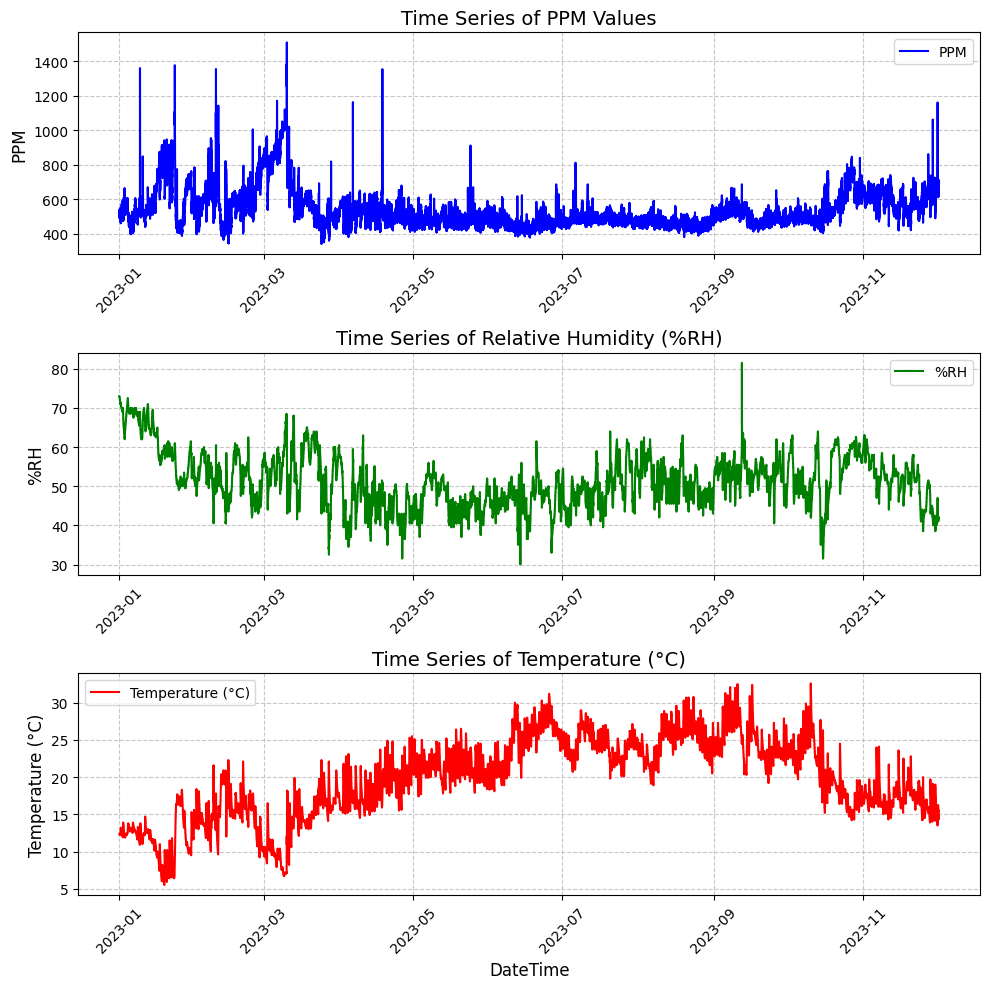

In [26]:
# Visualizing EcoLab Ground Data: PPM, RH, and Temperature
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Plot ppm
axes[0].plot(df_ppm['DateTime'], df_ppm['Value'], color='blue', label='PPM')
axes[0].set_title('Time Series of PPM Values', fontsize=14)
axes[0].set_ylabel('PPM', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(fontsize=10)

# Plot %RH
axes[1].plot(df_rh['DateTime'], df_rh['Value'], color='green', label='%RH')
axes[1].set_title('Time Series of Relative Humidity (%RH)', fontsize=14)
axes[1].set_ylabel('%RH', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=10)

# Plot °C
axes[2].plot(df_c['DateTime'], df_c['Value'], color='red', label='Temperature (°C)')
axes[2].set_title('Time Series of Temperature (°C)', fontsize=14)
axes[2].set_xlabel('DateTime', fontsize=12)
axes[2].set_ylabel('Temperature (°C)', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend(fontsize=10)

# Adjust x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

### Data Clean and Preprocessing
*Handle Outliers in EcoLab Ground Data*

In [27]:
# Convert DateTime column to datetime format
df_inv['DateTime'] = pd.to_datetime(df_inv['DateTime'], errors='coerce')

# Remove rows with invalid DateTime or missing data
df_inv = df_inv.dropna(subset=['DateTime', 'Value'])

# Filter dataset for relevant units: ppm, %RH, °C
df_ppm = df_inv[df_inv['Unit'] == 'ppm'].copy()
df_rh = df_inv[df_inv['Unit'] == '%RH'].copy()
df_temp = df_inv[df_inv['Unit'] == '°C'].copy()

# Ensure 'Value' column is numeric
df_ppm['Value'] = pd.to_numeric(df_ppm['Value'], errors='coerce')
df_rh['Value'] = pd.to_numeric(df_rh['Value'], errors='coerce')
df_temp['Value'] = pd.to_numeric(df_temp['Value'], errors='coerce')

# Handle outliers and interpolate
# PPM
ppm_threshold = 1000  # Set threshold
df_ppm['Value'] = df_ppm['Value'].where(df_ppm['Value'] <= ppm_threshold, np.nan)
df_ppm['Value'] = df_ppm['Value'].interpolate(method='linear', limit_direction='both')

# %RH
rh_min, rh_max = 20, 80  # Set reasonable range for %RH
df_rh['Value'] = df_rh['Value'].where((df_rh['Value'] >= rh_min) & (df_rh['Value'] <= rh_max), np.nan)
df_rh['Value'] = df_rh['Value'].interpolate(method='linear', limit_direction='both')

# Temperature (°C)
temp_threshold = 30  # Set threshold
df_temp['Value'] = df_temp['Value'].where(df_temp['Value'] <= temp_threshold, np.nan)
df_temp['Value'] = df_temp['Value'].interpolate(method='linear', limit_direction='both')

# Combine cleaned datasets
df2_clean = pd.concat([df_ppm, df_rh, df_temp]).sort_values(by="DateTime").reset_index(drop=True)

# Verify the structure of the cleaned dataset
print(df2_clean.head())

                  Sensor            DateTime  Value Unit
0  EcoLab Ground (CO107) 2022-12-31 23:53:24  518.0  ppm
1   EcoLab Ground (H107) 2022-12-31 23:53:24   73.0  %RH
2   EcoLab Ground (T107) 2022-12-31 23:53:24   12.3   °C
3  EcoLab Ground (CO107) 2023-01-01 00:00:55  520.0  ppm
4   EcoLab Ground (H107) 2023-01-01 00:00:55   73.0  %RH


In [28]:
# Display the column names of the cleaned dataset
df2_clean.columns

Index(['Sensor', 'DateTime', 'Value', 'Unit'], dtype='object')

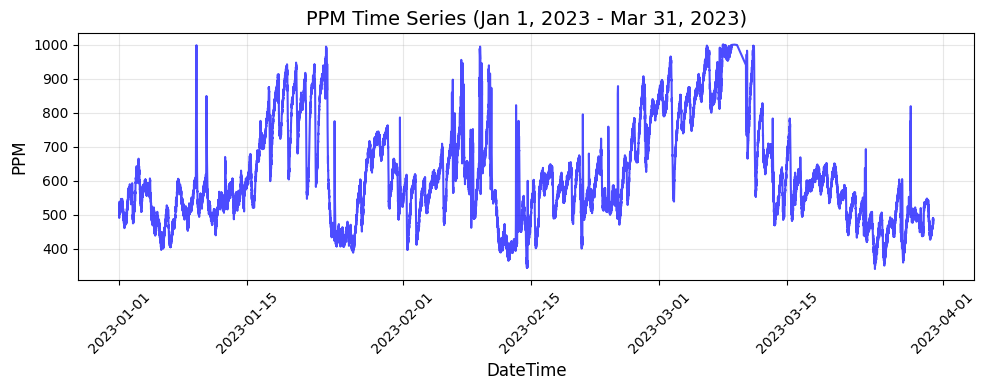

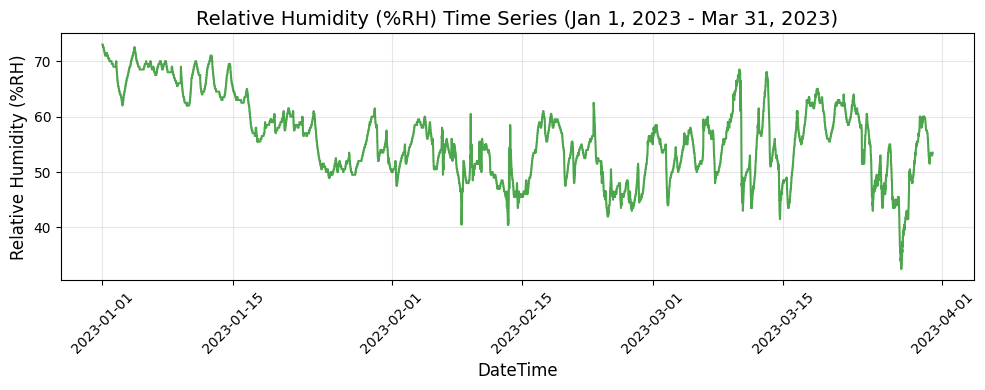

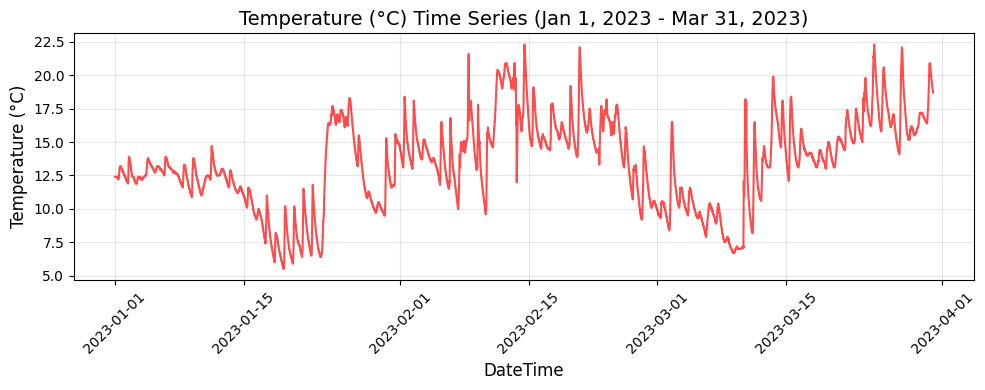

In [29]:
# Filter each subset for the date range
start_date = '2023-01-01'
end_date = '2023-03-31'
df_ppm_filtered = df_ppm[(df_ppm['DateTime'] >= start_date) & (df_ppm['DateTime'] <= end_date)]
df_rh_filtered = df_rh[(df_rh['DateTime'] >= start_date) & (df_rh['DateTime'] <= end_date)]
df_temp_filtered = df_temp[(df_temp['DateTime'] >= start_date) & (df_temp['DateTime'] <= end_date)]

# Plotting PPM
plt.figure(figsize=(10, 4))
plt.plot(df_ppm_filtered['DateTime'], df_ppm_filtered['Value'], label='PPM', color='blue', alpha=0.7)
plt.title('PPM Time Series (Jan 1, 2023 - Mar 31, 2023)', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('PPM', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting RH
plt.figure(figsize=(10, 4))
plt.plot(df_rh_filtered['DateTime'], df_rh_filtered['Value'], label='%RH', color='green', alpha=0.7)
plt.title('Relative Humidity (%RH) Time Series (Jan 1, 2023 - Mar 31, 2023)', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Relative Humidity (%RH)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting Temperature
plt.figure(figsize=(10, 4))
plt.plot(df_temp_filtered['DateTime'], df_temp_filtered['Value'], label='Temp (°C)', color='red', alpha=0.7)
plt.title('Temperature (°C) Time Series (Jan 1, 2023 - Mar 31, 2023)', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

*Saved Clean Version of EcoLab Ground Data to Use for Model Predictions*

In [30]:
# Define the output directory and file path
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)
cleaned_df2 = os.path.join(output_dir, "EcoLab Ground Cleaned.csv")

# Save the cleaned dataset to a CSV file
df2_clean.to_csv(cleaned_df2, index=False)

cleaned_df2

'./data/EcoLab Ground Cleaned.csv'

# Weather Link Indoor and Outdoor 2023
## Sensor 3 Data: Weather Link Indoor

In [31]:
# Aarons File Path
#weather_data = "./Smart House 2023 datapack CC BY-NC/WeatherLink Indoor and Outdoor 2023/Weather Link Indoor.csv"
#df_wLink = pd.read_csv(data, engine="python", encoding="ISO-8859-1", skiprows=5)

# Detect the encoding
#with open(weather_data, "rb") as f:
    #result = chardet.detect(f.read())
    #print(result)

### Data Understanding and EDA

In [32]:
# Dataframe Initial Head
df_wLink.head()

,Date & Time,Inside Temp - °C,High Inside Temp - °C,Low Inside Temp - °C,Inside Hum - %,High Inside Hum - %,Low Inside Hum - %,Inside Dew Point - °C,Inside Heat Index - °C,Barometer - mb,High Bar - mb,Low Bar - mb,Absolute Pressure - mb
0,1/1/23 00:00,13,13,13,68,68,68,8,13,1002.6,1002.6,1002.6,999.6
1,1/1/23 00:15,13,13,13,68,69,68,8,13,1002.7,1002.8,1002.6,999.7
2,1/1/23 00:30,13,13,13,68,69,68,8,13,1002.6,1002.9,1002.6,999.6
3,1/1/23 00:45,13,14,13,68,68,68,8,13,1002.7,1002.9,1002.6,999.8
4,1/1/23 01:00,13,14,13,68,68,68,8,13,1002.7,1002.8,1002.7,999.7


In [33]:
# Print Initial Data
df_wLink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52864 entries, 0 to 52863
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date & Time             52864 non-null  object 
 1   Inside Temp - °C        52864 non-null  int64  
 2   High Inside Temp - °C   52864 non-null  int64  
 3   Low Inside Temp - °C    52864 non-null  int64  
 4   Inside Hum - %          52864 non-null  int64  
 5   High Inside Hum - %     52864 non-null  int64  
 6   Low Inside Hum - %      52864 non-null  int64  
 7   Inside Dew Point - °C   52864 non-null  int64  
 8   Inside Heat Index - °C  52864 non-null  int64  
 9   Barometer - mb          52864 non-null  float64
 10  High Bar - mb           52864 non-null  float64
 11  Low Bar - mb            52864 non-null  float64
 12  Absolute Pressure - mb  52864 non-null  float64
dtypes: float64(4), int64(8), object(1)
memory usage: 5.2+ MB


### Data Cleaning and Preprocessing

In [34]:
# Remove unnecessary columns
#df_wLink = df_wLink.drop(columns=['High Inside Temp - °C', 'Low Inside Temp - °C', "High Inside Hum - %", "Low Inside Hum - %", "High Bar - mb", "Low Bar - mb"  ])

*Feature Engineering*

In [35]:
# Create the cleaned dataset
df_wLink_cleaned = df_wLink.copy()

# Retain Relevant Columns and Create Derived Features
df_wLink_cleaned['Temp Range - °C'] = df_wLink_cleaned['High Inside Temp - °C'] - df_wLink_cleaned['Low Inside Temp - °C']
df_wLink_cleaned['Humidity Range - %'] = df_wLink_cleaned['High Inside Hum - %'] - df_wLink_cleaned['Low Inside Hum - %']
df_wLink_cleaned['Pressure Range - mb'] = df_wLink_cleaned['High Bar - mb'] - df_wLink_cleaned['Low Bar - mb']

# Remove Unnecessary Columns
df_wLink_cleaned = df_wLink_cleaned.drop(columns=[
    'High Inside Temp - °C', 'Low Inside Temp - °C',
    'High Inside Hum - %', 'Low Inside Hum - %',
    'High Bar - mb', 'Low Bar - mb'
])

*Standardize Date Format*

In [36]:
# Standardize the Date Format
def standardize_date(date_str):
    try:
        dt = datetime.strptime(date_str, "%d/%m/%Y %H:%M")  # e.g., "1/1/2023 0:00"
    except ValueError:
        try:
            dt = datetime.strptime(date_str, "%d/%m/%y %H:%M")  # e.g., "13/1/23 00:00"
        except ValueError:
            return None
    return dt.strftime("%Y-%m-%d %H:%M:%S")

df_wLink_cleaned['Date & Time'] = df_wLink_cleaned['Date & Time'].apply(standardize_date)
df_wLink_cleaned['Date & Time'] = pd.to_datetime(df_wLink_cleaned['Date & Time'])

*Display Clean Data*

In [37]:
# Verify the Cleaned DataFrame
df_wLink_cleaned.info()
df_wLink_cleaned.head()

# Print New Columns
df_wLink_cleaned.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52864 entries, 0 to 52863
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date & Time             52864 non-null  datetime64[ns]
 1   Inside Temp - °C        52864 non-null  int64         
 2   Inside Hum - %          52864 non-null  int64         
 3   Inside Dew Point - °C   52864 non-null  int64         
 4   Inside Heat Index - °C  52864 non-null  int64         
 5   Barometer - mb          52864 non-null  float64       
 6   Absolute Pressure - mb  52864 non-null  float64       
 7   Temp Range - °C         52864 non-null  int64         
 8   Humidity Range - %      52864 non-null  int64         
 9   Pressure Range - mb     52864 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 4.0 MB


Index(['Date & Time', 'Inside Temp - °C', 'Inside Hum - %',
       'Inside Dew Point - °C', 'Inside Heat Index - °C', 'Barometer - mb',
       'Absolute Pressure - mb', 'Temp Range - °C', 'Humidity Range - %',
       'Pressure Range - mb'],
      dtype='object')

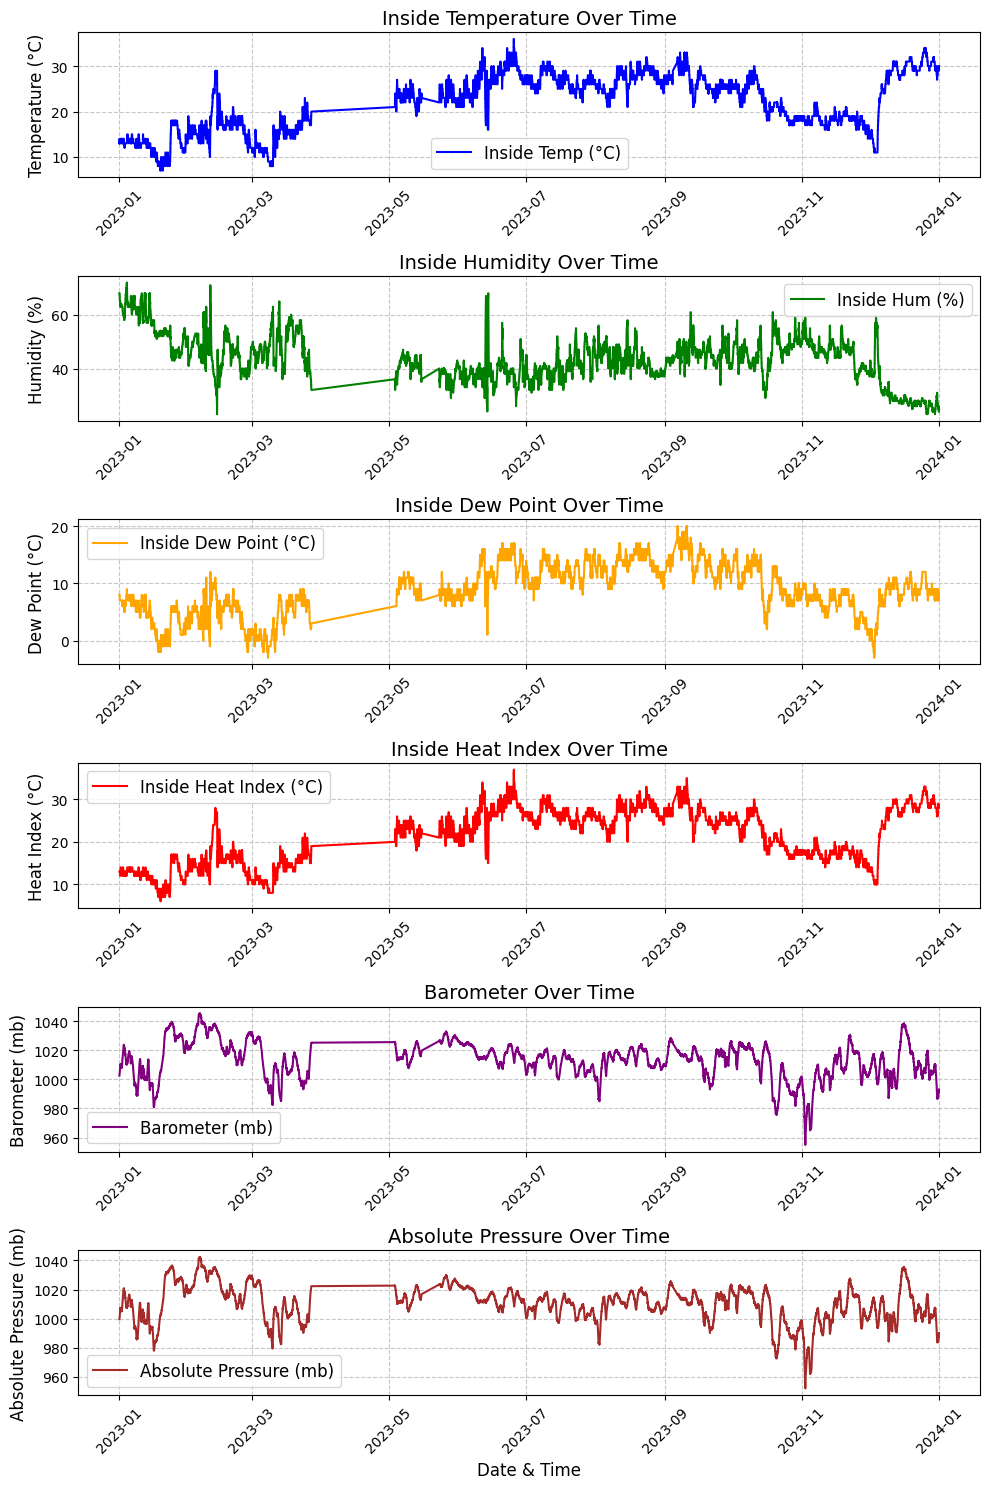

In [39]:
# Visualization for the Entire Dataset
fig, axes = plt.subplots(6, 1, figsize=(10, 15))

# Plot Inside Temperature
axes[0].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Inside Temp - °C'], color='blue', label='Inside Temp (°C)')
axes[0].set_title('Inside Temperature Over Time', fontsize=14)
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(fontsize=12)

# Plot Inside Humidity
axes[1].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Inside Hum - %'], color='green', label='Inside Hum (%)')
axes[1].set_title('Inside Humidity Over Time', fontsize=14)
axes[1].set_ylabel('Humidity (%)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=12)

# Plot Inside Dew Point
axes[2].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Inside Dew Point - °C'], color='orange', label='Inside Dew Point (°C)')
axes[2].set_title('Inside Dew Point Over Time', fontsize=14)
axes[2].set_ylabel('Dew Point (°C)', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend(fontsize=12)

# Plot Inside Heat Index
axes[3].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Inside Heat Index - °C'], color='red', label='Inside Heat Index (°C)')
axes[3].set_title('Inside Heat Index Over Time', fontsize=14)
axes[3].set_ylabel('Heat Index (°C)', fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.7)
axes[3].legend(fontsize=12)

# Plot Barometer
axes[4].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Barometer - mb'], color='purple', label='Barometer (mb)')
axes[4].set_title('Barometer Over Time', fontsize=14)
axes[4].set_ylabel('Barometer (mb)', fontsize=12)
axes[4].grid(True, linestyle='--', alpha=0.7)
axes[4].legend(fontsize=12)

# Plot Absolute Pressure
axes[5].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Absolute Pressure - mb'], color='brown', label='Absolute Pressure (mb)')
axes[5].set_title('Absolute Pressure Over Time', fontsize=14)
axes[5].set_xlabel('Date & Time', fontsize=12)
axes[5].set_ylabel('Absolute Pressure (mb)', fontsize=12)
axes[5].grid(True, linestyle='--', alpha=0.7)
axes[5].legend(fontsize=12)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

*View Filter Data to 3 month range*

In [44]:
# Define the date range
start_date = '2023-01-01'
end_date = '2023-03-31'

# Filter the DataFrame
df_wLink_filtered  = df_wLink_cleaned[(df_wLink_cleaned['Date & Time'] >= start_date) & (df_wLink_cleaned['Date & Time'] <= end_date)]

# Check the filtered data
df_wLink_filtered .head()

,Date & Time,Inside Temp - °C,Inside Hum - %,Inside Dew Point - °C,Inside Heat Index - °C,Barometer - mb,Absolute Pressure - mb,Temp Range - °C,Humidity Range - %,Pressure Range - mb
0,2023-01-01 00:00:00,13,68,8,13,1002.6,999.6,0,0,0.0
1,2023-01-01 00:15:00,13,68,8,13,1002.7,999.7,0,1,0.2
2,2023-01-01 00:30:00,13,68,8,13,1002.6,999.6,0,1,0.3
3,2023-01-01 00:45:00,13,68,8,13,1002.7,999.8,1,0,0.3
4,2023-01-01 01:00:00,13,68,8,13,1002.7,999.7,1,0,0.1


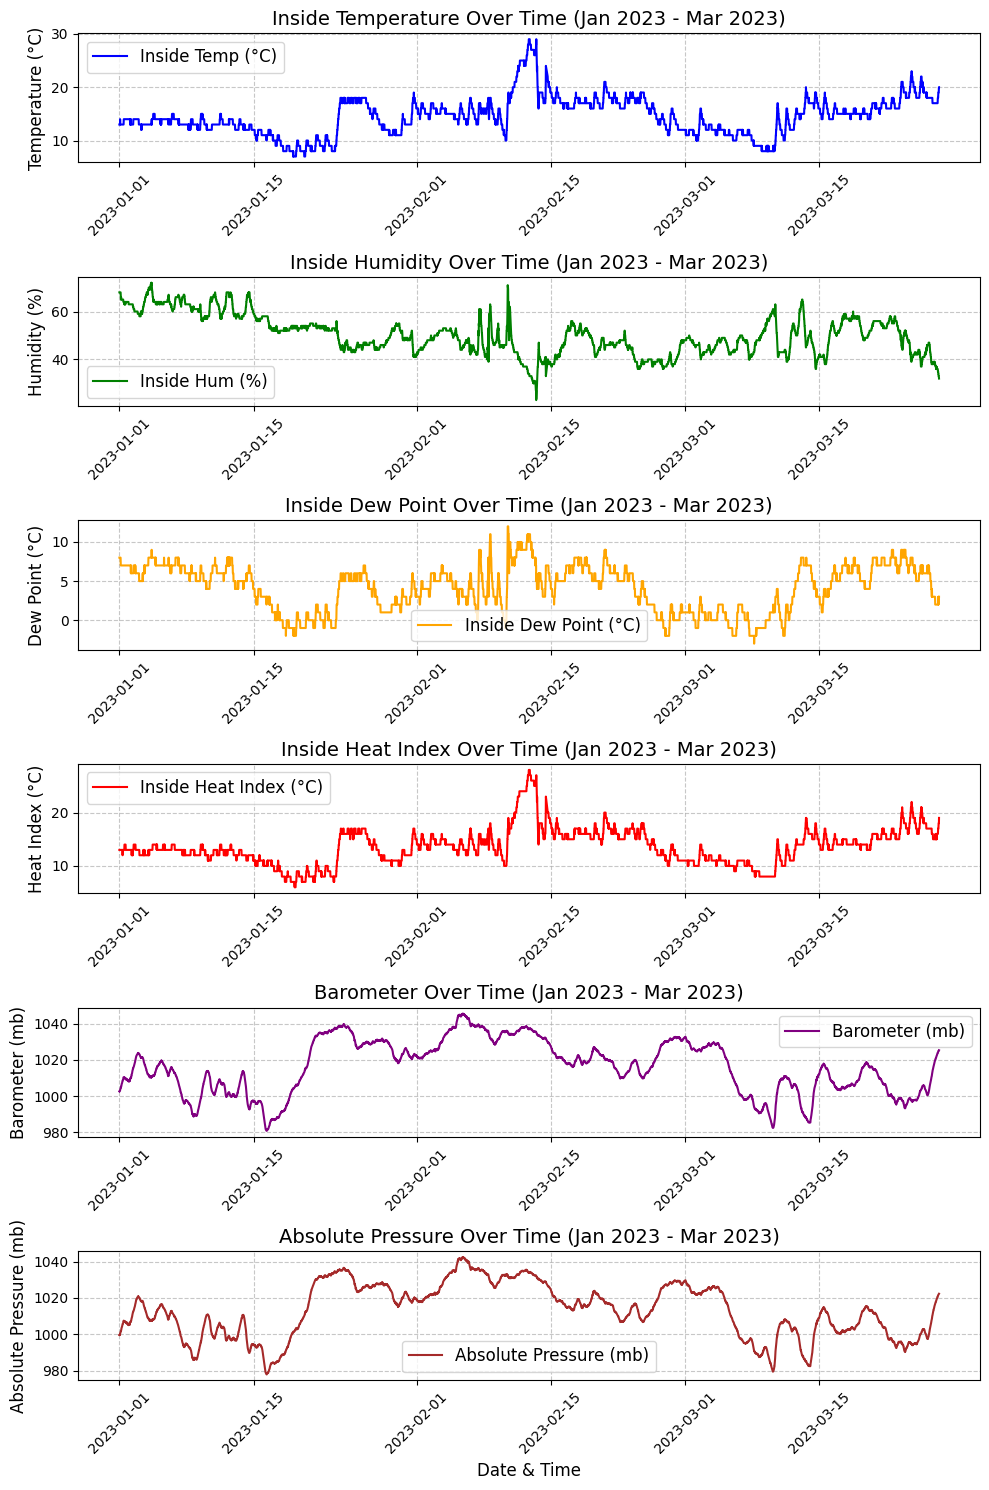

In [45]:
# Create a figure with 6 subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 15))

# Plot Inside Temperature
axes[0].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Inside Temp - °C'], color='blue', label='Inside Temp (°C)')
axes[0].set_title('Inside Temperature Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(fontsize=12)

# Plot Inside Humidity
axes[1].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Inside Hum - %'], color='green', label='Inside Hum (%)')
axes[1].set_title('Inside Humidity Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[1].set_ylabel('Humidity (%)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=12)

# Plot Inside Dew Point
axes[2].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Inside Dew Point - °C'], color='orange', label='Inside Dew Point (°C)')
axes[2].set_title('Inside Dew Point Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[2].set_ylabel('Dew Point (°C)', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend(fontsize=12)

# Plot Inside Heat Index
axes[3].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Inside Heat Index - °C'], color='red', label='Inside Heat Index (°C)')
axes[3].set_title('Inside Heat Index Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[3].set_ylabel('Heat Index (°C)', fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.7)
axes[3].legend(fontsize=12)

# Plot Barometer
axes[4].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Barometer - mb'], color='purple', label='Barometer (mb)')
axes[4].set_title('Barometer Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[4].set_ylabel('Barometer (mb)', fontsize=12)
axes[4].grid(True, linestyle='--', alpha=0.7)
axes[4].legend(fontsize=12)

# Plot Absolute Pressure
axes[5].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Absolute Pressure - mb'], color='brown', label='Absolute Pressure (mb)')
axes[5].set_title('Absolute Pressure Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[5].set_xlabel('Date & Time', fontsize=12)
axes[5].set_ylabel('Absolute Pressure (mb)', fontsize=12)
axes[5].grid(True, linestyle='--', alpha=0.7)
axes[5].legend(fontsize=12)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

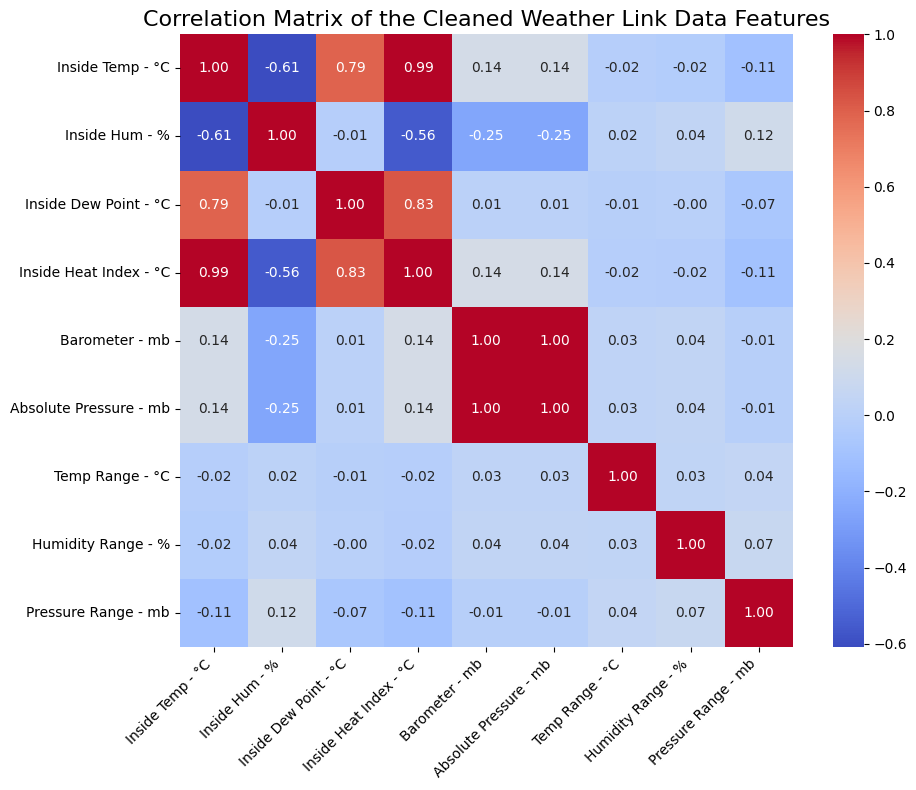

In [46]:
# Calculate correlation matrix for filtered data
correlation_matrix = df_wLink_cleaned.drop(columns=["Date & Time"]).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of the Cleaned Weather Link Data Features", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

*The correlation matrix shows that Inside Temp - °C, Inside Heat Index - °C, and Inside Dew Point - °C are strongly correlated, indicating these features are interrelated and may provide redundant information. Inside Hum - % is negatively correlated with temperature and heat index, reflecting the inverse relationship between temperature and relative humidity. Barometer - mb and Absolute Pressure - mb are perfectly correlated, while features like Pressure Range - mb and Temp Range - °C exhibit weak correlations with most variables, suggesting limited predictive value.*

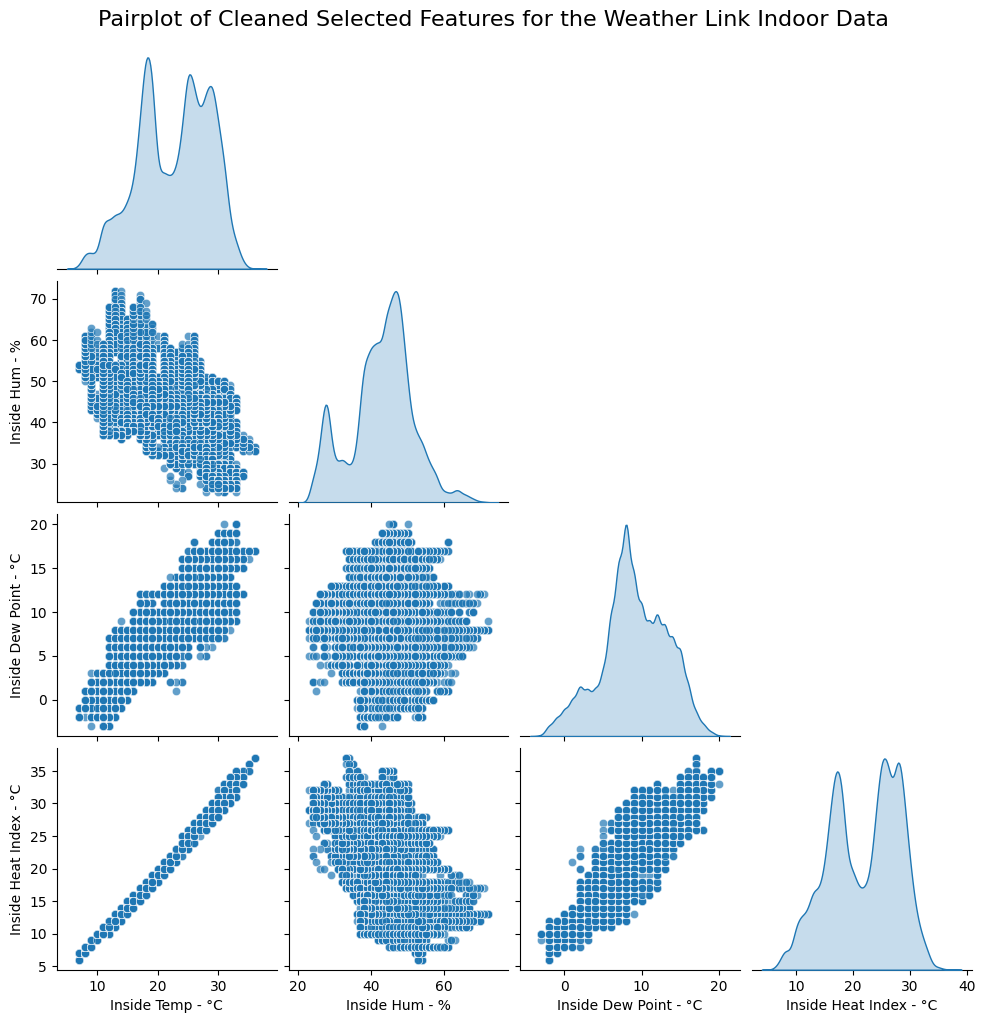

In [47]:
# Pairplot for selected features to visualize relationships
selected_features = [
    "Inside Temp - °C", "Inside Hum - %",
    "Inside Dew Point - °C", "Inside Heat Index - °C"
]
sns.pairplot(df_wLink_cleaned[selected_features], diag_kind="kde", corner=True, plot_kws={"alpha": 0.7})
plt.suptitle("Pairplot of Cleaned Selected Features for the Weather Link Indoor Data", y=1.02, fontsize=16)
plt.show()

*Inside Temp (°C) and Inside Heat Index (°C) exhibit a nearly linear correlation, while Inside Humidity (%) shows an inverse pattern with temperature-related features. Distributions along the diagonal suggest Inside Heat Index (°C) and Inside Humidity (%) have bimodal characteristics, which may point to distinct environmental states captured during the data period.*

*Saved Clean Version of Weather Link Indoor Data to Use for Model Predictions*

In [48]:
# Define the output directory and file path
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)
cleaned_df3 = os.path.join(output_dir, "Weather Link Indoor Cleaned.csv")

# Save the cleaned dataframe to a CSV file
df_wLink_cleaned.to_csv(cleaned_df3, index=False)

cleaned_df3

'./data/Weather Link Indoor Cleaned.csv'

***Need Before Modeling?***
* *Combine CSV?*
* *Feature Scaling (LSTM, CNN, TFT)*
* *Stationarity Check and Transformation (ARIMA)*
* *Define Target(s) - "Temp", (also "Humidity" and "Pressure" for TNT)*
* *Data Splitting*
* *Prepare Supervised Format (Deep Learning)*
* *Cross-Validation*
* *Address Class Imbalance*

## Data Split

## Models

**Sequence Modeling**<br>
*1. ARIMA: Establishes a statistical baseline by capturing trends and seasonality in the data.*<br>
*2. LSTM: Builds on ARIMA by modeling long-term dependencies in sequential data through deep learning.*<br>
*3. CNN: Focuses on detecting short-term patterns and local features in the time series.*<br>
*4. TFT: Combines all insights for advanced multi-horizon forecasting with state-of-the-art accuracy.*

### Time-Series Model
*ARIMA (Autoregressive Integrated Moving Average)*

### Deep Learning Model
*LSTM (Long Short-Term Memory)*

### Deep Learning Model
*CNN (Convolutional Neural Network)*

### Time-Series Models
*TNT (Temporal Fusion Transformer)*